In [27]:
import os
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import copy

In [28]:
# 1. 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# 2. 超参数
batch_size = 32
num_epochs = 20
early_stop_patience = 3

In [30]:
# 3. 数据预处理
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [31]:
# 3. 数据加载
train_data = ImageFolder('dataset/train', transform=train_transforms)
val_data = ImageFolder('dataset/val', transform=val_test_transforms)
test_data = ImageFolder('dataset/test', transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [32]:
# 4. 使用预训练模型（ResNet18）并修改输出层
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# 新建一个带 Dropout 的分类器结构
model.fc = nn.Sequential(
    nn.Dropout(0.5),          # Dropout 概率可以调，例如 0.3~0.5
    nn.Linear(num_features, 2)
)

model = model.to(device)

d:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# 5. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-3)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)


In [34]:
# 6. 模型训练
# 训练 + 验证
best_val_acc = 0
patience = 5
min_delta=0.001
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_data)
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    # 验证
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = val_correct / len(val_data)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step(val_loss)

Epoch 1/20 | Train Acc: 0.5906 | Val Acc: 0.6875
Epoch 2/20 | Train Acc: 0.7406 | Val Acc: 0.5750
Epoch 3/20 | Train Acc: 0.8281 | Val Acc: 0.5250
Epoch 4/20 | Train Acc: 0.8625 | Val Acc: 0.7250
Epoch 5/20 | Train Acc: 0.8781 | Val Acc: 0.7500
Epoch 6/20 | Train Acc: 0.8844 | Val Acc: 0.7000
Epoch 7/20 | Train Acc: 0.8906 | Val Acc: 0.7375
Epoch 8/20 | Train Acc: 0.8844 | Val Acc: 0.6125
Early stopping triggered!


In [35]:
# 保存最佳模型
torch.save(best_model, 'best_model.pth')
model.load_state_dict(best_model)


<All keys matched successfully>

In [36]:
# 7. 模型评估
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nTest Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))



Test Classification Report:
              precision    recall  f1-score   support

          AI       0.89      0.80      0.84        20
        Real       0.82      0.90      0.86        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



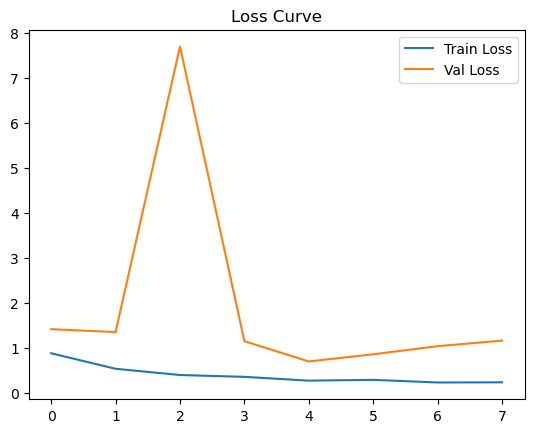

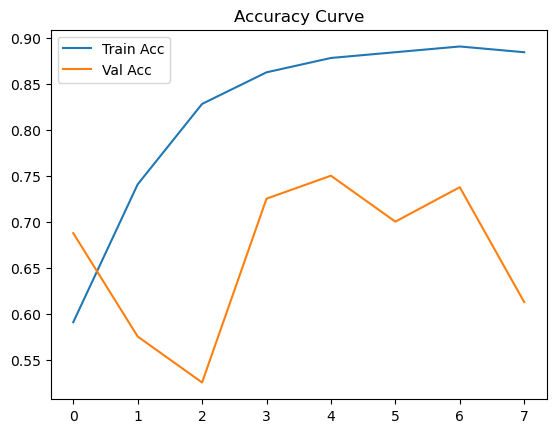

In [37]:
# 可视化
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [38]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

def predict_image(image_path, model, class_names, device='cpu'):
    # 加载并预处理图片
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 与训练保持一致
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # 若训练时使用了Normalize
    ])

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    # 输出结果
    print(f"预测结果：{class_names[predicted_class]}")
    print(f"类别概率：{probs.cpu().numpy()[0]}")


In [39]:
# 设置类别名（注意和训练时保持一致）
class_names = ['AI', 'Real']

# 假设你保存了模型为 best_model.pth，并用的是CPU
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

# 用图片路径调用预测
predict_image('DSCF4332.jpg', model, class_names)


预测结果：Real
类别概率：[0.08167081 0.9183291 ]
